# Data Preprocessing
- Gets the data for the selected stocks 
- Checks for problems and plots raw data
- Identifies stock splits and corrects for them as instructed by user
- Cleans data as needed
- Plots raw vs cleaned data
- Stores clean data in a new SQLite DB for further analysis

## User-defined variables
- Set path of SQLite DB file.
- Pick the stocks you want to process (leave list empty if you want to examine all stocks for which data is stored in the DB).
- Pick batch size - this is the number of stocks that will be processed for each run of this notebook (set to None to go through all stocks at once)
- Adjust threshold for automatic stock split detection if needed (there is also a method below for manually removing or entering split events). Lower thresholds will lead to increased false alarms but decreased misdetections compared to higher threshold values. Generally, speaking, it is better to have false alarms (and remove them) than misdetections (that might be difficult to observe on your own). 
- Adjust the minimal length of stock history to be considered for futher analysis (i.e., if a stock has been traded for much less time than the others, you might want to exclude it from your dataset).

In [1]:
#symbols = ["AAPL", "ABBV", "DD", "GE", "KVUE", "TECH", "RJF", "ROL", "GOOGL"] #example list for examining of specific stocks. 
symbols = [] #***If you intend to examine all stocks in the SQLite DB, leave the symbols list empty. 
#This is recommended if you want to produce a 'clean' DB.***
batch_size = 30 #number of stocks to pre-process each time you run the program. set to None to go through all of your existing data in one batch (slower and produces many figures).

overwrite_clean_tables = False #default=False: this will prevent pre-processing of data that already exists in the clean SQLite file.
#set to True if you want to reanalyze and overwrite existing tables in the clean SQLite database. 

min_duration_ratio = 0.5 #minimal length of timeseries compared to the maximal timeseries (i.e., for removing stocks that have been traded for less than a certain duration).

#If you have a google API key, use it to search for stock split/consolidation events (do not try to infer them from the data using split_ratio_threshold)
try:
    from google_api_key import GOOGLE_API_KEY
    SEARCH_ENGINE_ID = "71fe9f4eccb624a0f"
    play_nice = 5 #duration to wait between API requests (s)
    from ticker_to_company import Company #for getting company name for query
    if GOOGLE_API_KEY == 'place_your_key_here' :
        GOOGLE_API_KEY = None
except:
    GOOGLE_API_KEY = None

if GOOGLE_API_KEY is None: #if a google API key is not available
    split_ratio_threshold = 1.3 #minimal value of close/open (or open/close) price ratio that will trigger a split (or reverse split) warning. 
#using this threshold is fast, and doesn't require any API that would get actual split data from the web - however, it's less accurate (especially if a stock is very volatile).
#Therefore, it's recommended to cross-check with sources like https://companiesmarketcap.com 

#paths of SQLite DB files:
sqlite_file_path = './S&P 500.sqlite' #file containing raw data (produced by populate_SQL.py).
sqlite_file_path_clean = './S&P 500_clean_api.sqlite' #file that will contain only data that passed QC, and was adjusted for stock splits as required.
too_short_file = './too_short_to_analyze.txt' #file to store ticker symbols of stocks for which there's not enough data (so that they are not processed again)
#this is only effective if the symbols list is left empty (user can choose to examine any stock)

#### ....End of user-defined variables....

In [2]:
#import required libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import clear_output
import os
import requests
from bs4 import BeautifulSoup
import time

In [3]:
#connection and handle for existing SQLite DB
conn = sqlite3.connect(sqlite_file_path)
cur = conn.cursor()

#connection and handle for new SQLite file containing clean data, as well as the 'Stocks' table from the original SQL DB
conn_clean = sqlite3.connect(sqlite_file_path_clean)
cur_clean = conn_clean.cursor()

symbols = [symbol.upper().strip() for symbol in symbols] #in case user inputted lowercase

## Functions:

### Import and arrange data
- Check if any stocks were already considered and discarded in previous runs, and ignore them
- If user did not define stocks to be examined, retrieve info on all stocks with data
- Import SQL data into Pandas DataFrames, and load these dfs into a dictionary

In [4]:
def already_removed() :
    """Checks if data for a stock was already found to be too short in a previous run.
    This is done so that these data are not processed over and over again in the next batches.
          
    Returns:
        discarded_names (list) : List of stock symbols that have already been previously discarded and should not be considered. 
    """
    
    if not os.path.exists(too_short_file):
        with open(too_short_file, 'w') as file: pass #create txt file
        print(f"Creating a new file to store names of stocks with insufficient data at: {too_short_file}\n")

    else:
        with open(too_short_file, 'r') as file:
            discarded_names = [line.strip() for line in file]
        return discarded_names
    

discarded_names = already_removed()
    

In [5]:
def get_tables_w_data() :
    """Retrieves stock symbols for which data exists in the SQL file.
    
    Returns:
        list: A sorted list containing stock symbols (str) for which data is available.    
    """      
        
    cur.execute("SELECT name FROM sqlite_master WHERE type='table' AND name != 'Stocks'")
    stock_tables = [table[0] for table in cur.fetchall() if table[0] not in discarded_names]

    if not overwrite_clean_tables : #if we don't want to process data we've already cleaned
        cur_clean.execute("SELECT name FROM sqlite_master WHERE type='table' AND name != 'Stocks'")
        existing_clean_tables = [table[0] for table in cur_clean.fetchall()]
        stock_tables = [table for table in stock_tables if table not in existing_clean_tables]
        
    tables_w_data = []
    for i, table in enumerate(stock_tables):        
        cur.execute(f"SELECT COUNT(*) FROM '{table}'")
        cnt = cur.fetchone()[0]
        if cnt > 0 :
            tables_w_data.append(table)
        if i == batch_size-1 : break #if batch size is set, the length of the dataset will be restricted
    print(f"Data will be retrieved from {len(tables_w_data)} tables from {sqlite_file_path}:\n {tables_w_data}")
    
    return sorted(tables_w_data)

if len(symbols) == 0:
    symbols = get_tables_w_data()    

Data will be retrieved from 30 tables from ./S&P 500.sqlite:
 ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT']


In [6]:
def load_dfs_dict() :
    """Imports SQL data to Pandas DataFrames, sorts them by df.Date (ascending, for plotting), and stores these dfs in a dictionary.
    
    Returns:
        dfs (dict): A dictionary storing all datasets under consideration: key = stock symbol (str), value = stock data (pandas.DataFrame)  

    Raises: ValueError if dfs doesn't contain any data
    """ 

    dfs = dict()
    for symbol in symbols :  
        df = pd.read_sql(f"SELECT * FROM '{symbol}'", conn)
        df.sort_values('Date', inplace=True, ignore_index=True)
        dfs[symbol] = df

    if len(dfs) == 0:
        raise ValueError("No data selected for processing, please check and try again.")

    print(f"Created 'dfs' dictionary - contains data on {len(dfs)} stocks.")
    return dfs   

dfs = load_dfs_dict()


Created 'dfs' dictionary - contains data on 30 stocks.


### Basic quality control
- Ensure that data types are as expected
- Plot raw data for visual inspection
- Examine lengths of datasets and remove data that is too short compared to the others (as defined by min_duration_ratio)

In [7]:
def check_dtypes(dfs, flt_series_list, int_series) :
    """Basic test to ensure that data types of dfs are as expected.

    Args:
        dfs (dict): A dictionary storing all datasets under consideration: key = stock symbol (str), value = stock data (pandas.DataFrame).
    
    Returns:
        None

    Raises:
        TypeError: If series dtype not as expected. 
    """ 

    for symbol, df, in dfs.items() :
        for series in flt_series_list :
            if df[series].dtype != 'float64' :
                raise TypeError(f"Unexpected value encountered, check series {series.name} for df of stock {symbol} - dtype should be float64.")
        if df[int_series].dtype != 'int64' :
            raise TypeError(f"Unexpected value encountered, check series {int_series.name} for df of stock {symbol} - dtype should be int64.")
    
    print("Data types OK.")

check_dtypes(dfs, ['Open', 'Close', 'DailyChange', 'Low', 'High', 'DailyRange'], 'Volume') 

Data types OK.


In [8]:
"""Get maximum data length and corrseponding dates (for plotting of datasets with shorter timeseries using the same scale as others)."""

maxlen = max([len(df) for df in dfs.values()]) #maximum length of timeseries
for df in dfs.values():
    if len(df) == maxlen :
        date_list = df.Date.to_list() #list of dates from timeseries with maximum length
        break

In [9]:
def plot_stock_line(dfs):
    """Plot raw data (closing prices per trading day) - time axis (x) normalized for maximum duration in dataset.
    
    Args:
        dfs (dict): A dictionary storing all datasets under consideration: key = stock symbol (str), value = stock data (pandas.DataFrame).
    
    Returns:
        None 
    """ 

    num_plots = len(dfs)  # one subplot per df
    num_cols = 2 if len(dfs) > 1 else 1 #2 dfs per column
    num_rows = int(np.ceil(num_plots / num_cols)) # number of rows in figure
    width, height =7, 3
    

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(width*num_cols, 3*num_rows))
    if len(dfs) > 1 :
        axes = axes.flatten()
    else : 
        axes = [axes]

    plt.suptitle("Raw Price Data for Selected Stocks", y=1)

    for ax, (symbol, df) in zip(axes, dfs.items()) :
        if len(df) < maxlen : #for shorter time series, normalize x axis to entire historical period
            nan_list = [np.nan] * (maxlen-len(df))
            close_list = nan_list + df.Close.to_list()
            ax.plot(date_list, close_list)
            ax.set_xticks(date_list)
        else :
            ax.plot(df.Date, df.Close)
        ax.set_title(symbol)
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price (USD)')
        ax.tick_params(axis='x', labelrotation=45)
        ax.xaxis.set_major_locator(plt.MultipleLocator(maxlen // 5))

    plt.tight_layout(w_pad = 5, h_pad = 3)
    plt.show()
    

In [10]:
#version with multiple figs - for large datasets

def plot_stock_line_many(dfs):
    """Plot raw data (closing prices per trading day) for many stocks - time axis (x) normalized for maximum duration in dataset.
    Creates a new figure for every 100 stocks to handle large number of subplots. 
    
    Args:
        dfs (dict): A dictionary storing all datasets under consideration: key = stock symbol (str), value = stock data (pandas.DataFrame).
    
    Returns:
        None 
    """ 
    
    width = 7 #width and height of each subplot
    height = 3
    figs = [] #list for storing figures in case they get very big (100 stocks per figure)

    for i, (symbol, df) in enumerate(dfs.items()):
        if i % 100 == 0:  #create a new figure for every 100 subplots
            j = 0
            num_plots = min(100, len(dfs))  # number of subplots per fig - one subplot per df
            num_cols = 2 if (len(dfs) - i) > 1 else 1 #2 dfs per column
            num_rows = int(np.ceil(num_plots / num_cols)) # number of rows in figure
            #fig, axes = plt.subplots(num_rows, num_cols, figsize=(width*num_cols, height*num_rows))
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(width*num_cols, height*num_rows), 
                                     layout='constrained', gridspec_kw={'wspace': 0.1, 'hspace': 0.2})
            
            #plt.suptitle(f"Raw Price Data for Selected Stocks: {symbols[i]} - {symbols[min(i+99, len(dfs)-1)]}", y=1.05)
            plt.suptitle(f"Raw Price Data for Selected Stocks: {symbols[i]} - {symbols[min(i+99, len(dfs)-1)]}", y=1.01)
            figs.append(fig)  #store the created figure in a list
            
            if len(dfs) > 1:
                axes = axes.flatten()
            else : 
                axes = [axes]           
    
        ax = axes[j] #access the appropriate subplot
        j +=1
        
        if len(df) < maxlen : #for shorter time series, normalize x axis to entire historical period
            nan_list = [np.nan] * (maxlen-len(df))
            close_list = nan_list + df.Close.to_list()
            ax.plot(date_list, close_list)
            ax.set_xticks(date_list)
        else :
            ax.plot(df.Date, df.Close)
        ax.set_title(symbol)
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price (USD)')
        ax.tick_params(axis='x', labelrotation=45)
        ax.xaxis.set_major_locator(plt.MultipleLocator(maxlen // 5))

    
    for i, fig in enumerate(figs, start=1): #show all figures       
        plt.show(fig)



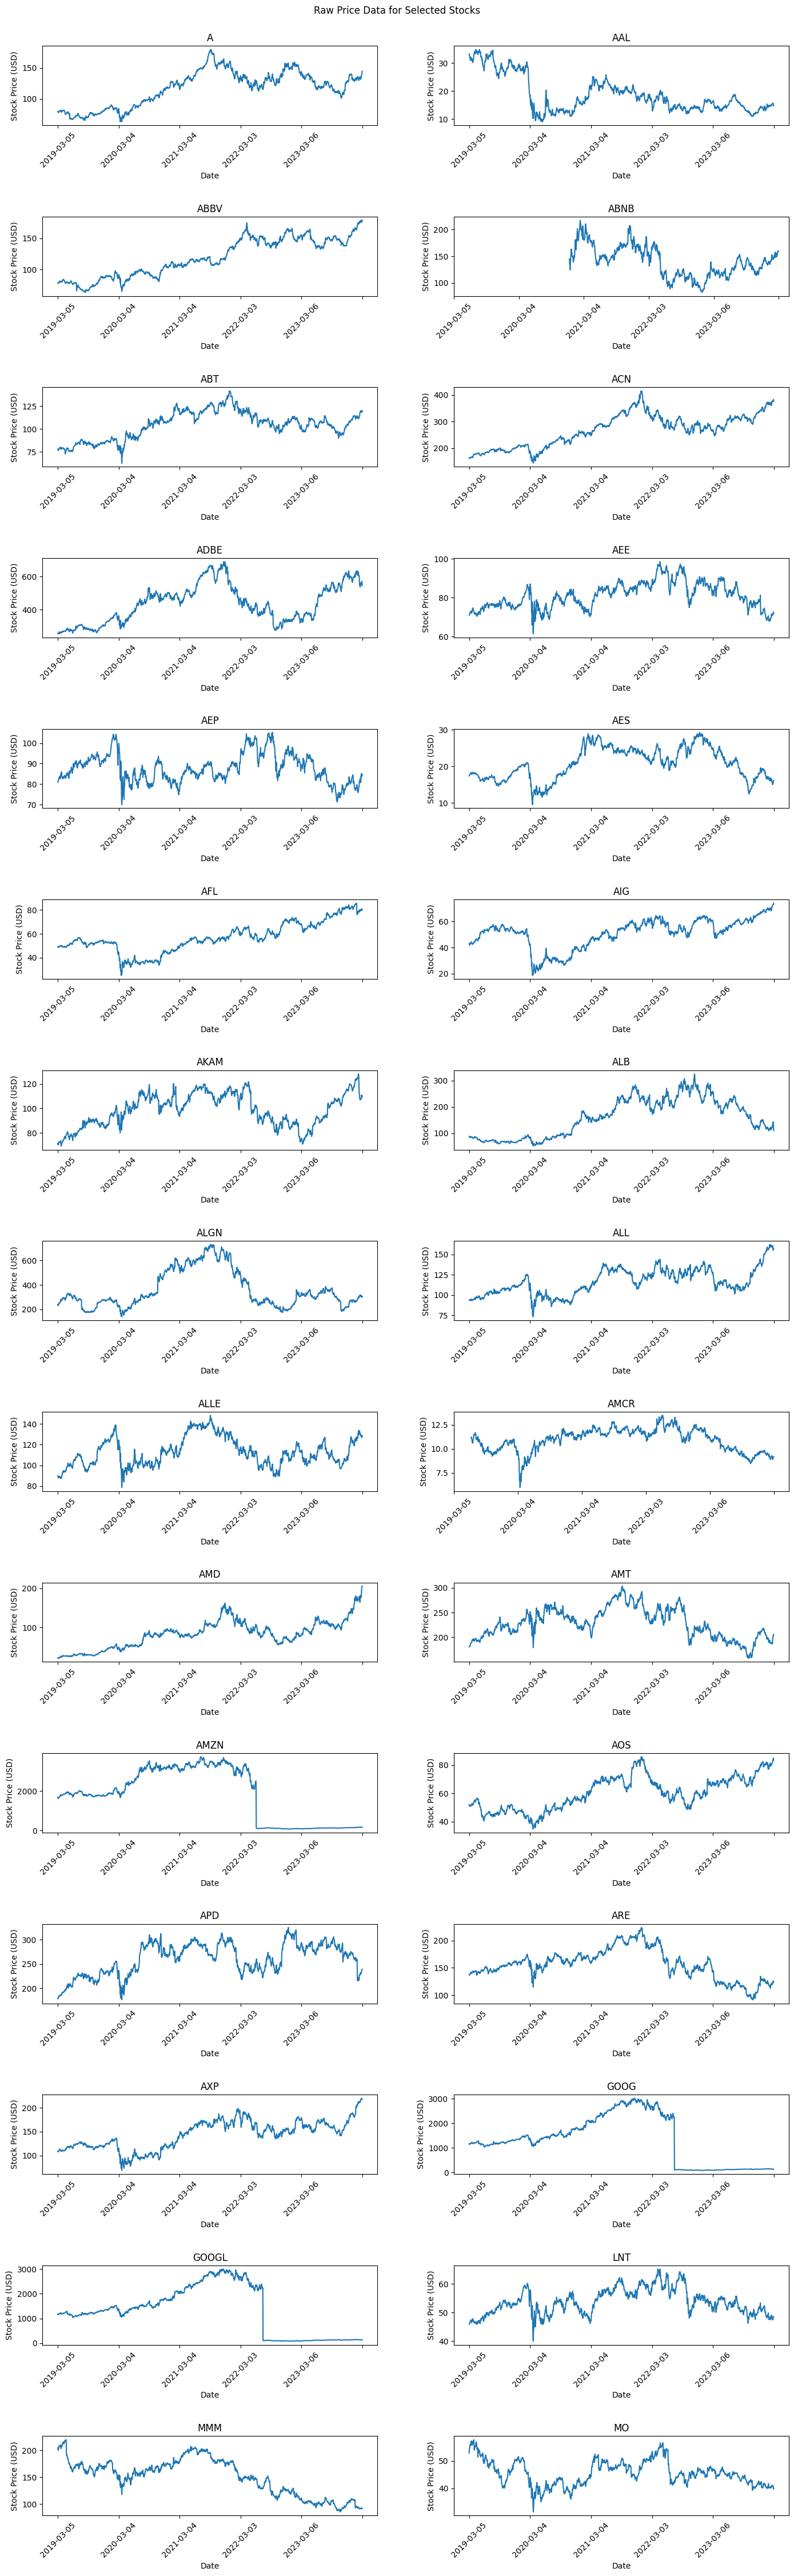

In [11]:
if len(dfs) >= 100 :
    plot_stock_line_many(dfs)
else:
    plot_stock_line(dfs)

In [12]:
def check_df_lens(dfs) :
    """If a dataset is too short (as defined by min_duration_ratio), it will not be stored in the 'clean' database
    and will not be considered in future analyses. 
    
    Args:
        dfs (dict): A dictionary storing all datasets under consideration: key = stock symbol (str), value = stock data (pandas.DataFrame).
        
    Returns:
        dfs (dict): The modified dfs dict, without excluded data. 
    """ 

    dfs_to_remove = []

    for symbol, df in dfs.items():
        if len(df) < (maxlen * min_duration_ratio) :
            dfs_to_remove.append(symbol)
            with open(too_short_file, 'a') as file: #store file name in txt file, to be ignored next time
                file.write(symbol + '\n')

    dfs = {key: value for key, value in dfs.items() if key not in dfs_to_remove}

    if len(dfs_to_remove) > 0 :
        print(f"{len(dfs_to_remove)} datasets were found to be too short (shorter than {100*min_duration_ratio}% of longest dataset), and will be excluded from the 'clean' database : {dfs_to_remove}")
    else :
        print(f"No dataset was removed due to being too short (shorter than {100*min_duration_ratio}% of longest dataset).")

    return dfs

dfs = check_df_lens(dfs)

No dataset was removed due to being too short (shorter than 50.0% of longest dataset).


## Adjust data for stock splits (including reverse splits = consolidations)
- If google API enabled, use it to get stock split/consolidation events and adjust price data accordingly
- If google API not available, use sudden changes in stock price (as defined by split_ratio_threshold) to automatically detect stock split events
- Create a DataFrame holding the info regarding all splits detected
- Allow user to remove or add split events as needed
- Plot adjusted data together with original data to visualize split adjustments

In [13]:
def build_payload(query, start=1, num=3):
    """
    Used for sending requests to the google search API, if an API key is available.

    Args:
        query (str): Search query
        start (int): Index of the first result to return
        num (in): Number of results to return
        
    Returns:
        payload (dict): Dictionary containing the API request parameters
    """
        
    payload = {
        'key': GOOGLE_API_KEY, 
        'q': query,
        'cx': SEARCH_ENGINE_ID,
        'start': start,
        'num': num
    }
    
    return payload   
    


In [14]:
def make_request(payload) :
    """
    Makes the request to the google API to get the URL of the page where stock split info exists.

    Args:
        payload (dict): Dictionary containing the API request parameters    
    
    Returns:
        dict: JSON response from the API
        None if the API returns a 429 code

    Raises: Exception if status code is not 200 or 429
    """
    
    response=requests.get('https://www.googleapis.com/customsearch/v1', params=payload)
    if response.status_code != 200 :
        if response.status_code == 429 :
            print("You may have exceeded your daily query limit from Google, batch will be shortened to current point.")
            return None
        raise Exception(f"Request to google search API failed, status code: {response.status_code}")    
    
    return response.json()

In [15]:
def split_from_web(url, company, symbol) :
    """
    Extracts info about splits from the relevant webpage. 

    Args:
        url (str): Link to webpage potentially holding stock split info
    
    Returns:
        tuple: A tuple containing 2 lists: dates and ratios of split/consolidation events for this stock
    """

    response = requests.get(url) 
    if not response.ok :
        print(f"Webpage {url} could not be accessed (code : {response.status_code}). Split info for {company.name} (ticker symbol '{symbol}') could not be reached.")
        return None
    content = response.content
    soup = BeautifulSoup(content, 'html.parser')
    tables = soup('table')
    if len(tables) == 0 : return None #no table containing split events     

    split_table = None
    for i, table in enumerate(tables) :
        for header in table('th'):
            if "Split" in header.string :
                split_table = tables[i]
                break
    if split_table is None : return None #no table containing split events

    rows = split_table('tr')
    dates = []
    ratios = []    
    for row in rows[1:] : #go through all rows (except headers)
        cells = row('td')
        dates.append(cells[0].string)
        ratios.append(cells[1].string)

    return dates, ratios

In [16]:
def retrieve_splits_from_api(dfs):
    """Uses a custom google search to find stock split/consolidation event data for each stock (requires a google API key).
    
    Args:
        dfs (dict): A dictionary storing all datasets under consideration: key = stock symbol (str), value = stock data (pandas.DataFrame)
        
    Returns:
        api_split_df (pandas.DataFrame): A DataFrame holding info on retrieved split events
    """ 

    api_split_df = pd.DataFrame(columns=['Stock', 'Date', 'SplitRatio'])
    domain = 'marketcap.com'
    suffix = 'stock-splits'
    split_checked = [] #list of symbols for which split was already checked - in case batch is interrupted midway (e.g., by 429 response)

    for i, (symbol, df) in enumerate(dfs.items()) :  
        if i > 0 :
            print(f"Split data for {i} stocks scanned so far - {len(api_split_df)} split/consolidation events detected in relevant period....", end='\r')
            time.sleep(play_nice) #wait a bit 

        company = Company(symbol)
        payload = build_payload(f'"{company.name}"')
        data = make_request(payload)        

        if data is None: #429 code returned - API limit reached
            dfs = {key: value for key, value in dfs.items() if key in split_checked}
            return dfs, api_split_df #move on to next parts with only split_checked 

        split_checked.append(symbol) #add split-checked stock to list           

        if 'items' not in data.keys(): continue #no relevant search results, move to next stock

        for item in data['items']:             
            if domain and suffix in item['link']:
                link = item['link']
                break
        else: #no relevant link found
            print(f"Stock split/consolidation info could not be reached for {company.name} (ticker symbol '{symbol}'.)")
            continue #move on to next stock

        split_data = split_from_web(link, company, symbol)
        if split_data is None: continue #no split events found for this stock, move to next stock
        
        dates, ratios = split_data

        for date, ratio in zip(dates, ratios) :  
            if df.Date.str.contains(date).any() :
                api_split_df.loc[len(api_split_df)] = [symbol, date, ratio]                       
                
    return dfs, api_split_df



In [17]:
def calc_ratio(large, small, event_type) :
    """Called by detect_splits() to calculate the most probable split ratio based on the sudden change in price detected. 
    Can detect splits/consolidations of up to 20:1. 
    
    Args:
        large (pandas.Series): The series (Open/Close) that holds the larger value for the suspected split date. 
            For a split the closing price would be higher than the next opening price, and vice versa for a reverse split (stock consolidation).
        small (pandas.Series): The series (Open/Close) that holds the smaller value for the suspected split date.
        event_type (str): A string indicating what kind of event was identified by detect_splits().
        
    Returns:
        best_guess (tuple): A tuple containing 2 integers that represent the split ratio.
    """ 

    best_guess = np.array([2, 1])    

    for l in range(2, 21):
        s_values = np.arange(1, l)
        ratios = np.abs(large/small - l/s_values)
        min_index = np.argmin(ratios)
        if ratios[min_index] < np.abs(large/small - best_guess[0]/best_guess[1]):
            best_guess = np.array([l, s_values[min_index]])
        
    if event_type == 'consolidation' :
        best_guess = tuple(reversed(best_guess))
    else: 
        best_guess = tuple(best_guess)

    return best_guess


In [18]:
def detect_splits(dfs):
    """Finds instances of sudden changes in stock price and consider them to be split events if they exceed the split_ratio_threshold. 
    
    Args:
        dfs (dict): A dictionary storing all datasets under consideration: key = stock symbol (str), value = stock data (pandas.DataFrame).
        
    Returns:
        split_df (pandas.DataFrame): A DataFrame holding info on detected split events. 
    """ 

    split_df = pd.DataFrame(columns=['Stock', 'Date', 'SplitRatio'])

    for symbol, df in dfs.items() :
        for i in range(1, len(df.Open)) :            
            if (df.Close.loc[i-1] / df.Open.loc[i]) > split_ratio_threshold : #stock split
                ratio = calc_ratio(df.Close.loc[i-1], df.Open.loc[i], 'split')                
            elif (df.Open.loc[i] / df.Close.loc[i-1]) > split_ratio_threshold : #stock consolidation (reverse split)
                ratio = calc_ratio(df.Open.loc[i], df.Close.loc[i-1], 'consolidation')                
            else : continue #no supra-threshold change detected

            str_ratio = f"{ratio[0]}:{ratio[1]}"
            date = df.Date.loc[i]
            split_df.loc[len(split_df)] = [symbol, date, str_ratio]                      
                
    return split_df


In [19]:
def split_query(split_df) :
    """Get user input on split_df. 
    
    Args:
        split_df (pandas.DataFrame): A DataFrame holding info on detected split events.
        
    Returns:
        split_df (pandas.DataFrame): The (user-accepted) split events DataFrame. 
    """ 
    
    while True :      
        display(split_df)
        to_split = input('''Please examine split events data shown above. It is recommended to check sources such as https://companiesmarketcap.com\n
-To accept all split events data as-is, press ENTER. 
-To exclude rows, enter the row numbers to exclude (separated by spaces).
-To manually insert a row, enter a list containing [stock symbol, date (YYYY-MM-DD), split ratio (after:before)]\n\n''').strip()
        
        if to_split != '' :
            if to_split.startswith('[') and to_split.endswith(']'):
                additions = to_split[1:-1].split(',')
                additions = [a.upper().strip() for a in additions]
                split_df.loc[len(split_df)] = additions
                split_df.sort_values('Stock', inplace=True, ignore_index=True)                
                clear_output()
                print("***Split event added manually - please check modified split events table (sorted by stock symbol):***\n")                
            else :
                exceptions = [int(i) for i in to_split.split()]
                split_df.drop(exceptions, inplace=True)
                split_df.reset_index(drop=True, inplace=True)
                clear_output()
                print("***Exceptions removed - please check modified split events table:***\n")
        else :
            clear_output()
            print('Listed split events accepted. Data will be adjusted accordingly.\n') 
            return split_df

In [20]:
if GOOGLE_API_KEY is not None: 
    print("Retrieving stock split/consolidation events from web - this might take a while!")
    dfs, split_df = retrieve_splits_from_api(dfs) #retrieve split info from web if google API key available
    
else :
    split_df = detect_splits(dfs) #find anomalies that are suspected as stock splits (no API needed - faster, but less accurate and requires more manual inspection)

split_query(split_df)

Listed split events accepted. Data will be adjusted accordingly.



,Stock,Date,SplitRatio
0,AMZN,2022-06-06,20:1
1,GOOG,2022-07-18,20:1
2,GOOGL,2022-07-18,20:1


In [21]:
def adjust_for_split(dfs, split_df) :
    """Uses info found in split_df to split-adjust data. 
    
    Args:
        dfs (dict): A dictionary storing all datasets under consideration: key = stock symbol (str), value = stock data (pandas.DataFrame).
        split_df (pandas.DataFrame): A DataFrame holding info on user-accepted split events.        
        
    Returns:
        adjusted_dfs (dict): A dictionary storing all datasets in which a split adjustment was made: 
                            key = stock symbol (str), value = split-adjusted stock data (pandas.DataFrame).
    """ 

    adjusted_dfs = dict()
    columns_to_divide = ['Open', 'Close', 'Low', 'High', 'DailyRange']

    #go through all rows of split_df and adjust trading data from dfs as necessary
    for index, row in split_df.iterrows() : 
        symbol = row.Stock
        split_date = row.Date
        ratio_num1, ratio_num2 = row.SplitRatio.split(':')
        split_ratio = float(ratio_num1) / float(ratio_num2)

        if symbol not in adjusted_dfs :
            adj_df = dfs[symbol].copy()
        else :
            adj_df = adjusted_dfs[symbol]

        adj_df.loc[adj_df.Date < split_date, columns_to_divide] /= split_ratio
        adj_df.loc[adj_df.Date < split_date, 'Volume'] *= split_ratio

        adjusted_dfs[symbol] = adj_df #store split-adjusted data

    print(f"Data has been split-adjusted for the following stocks : {list(adjusted_dfs.keys())}")

    return adjusted_dfs

adjusted_dfs = adjust_for_split(dfs, split_df)             

Data has been split-adjusted for the following stocks : ['AMZN', 'GOOG', 'GOOGL']


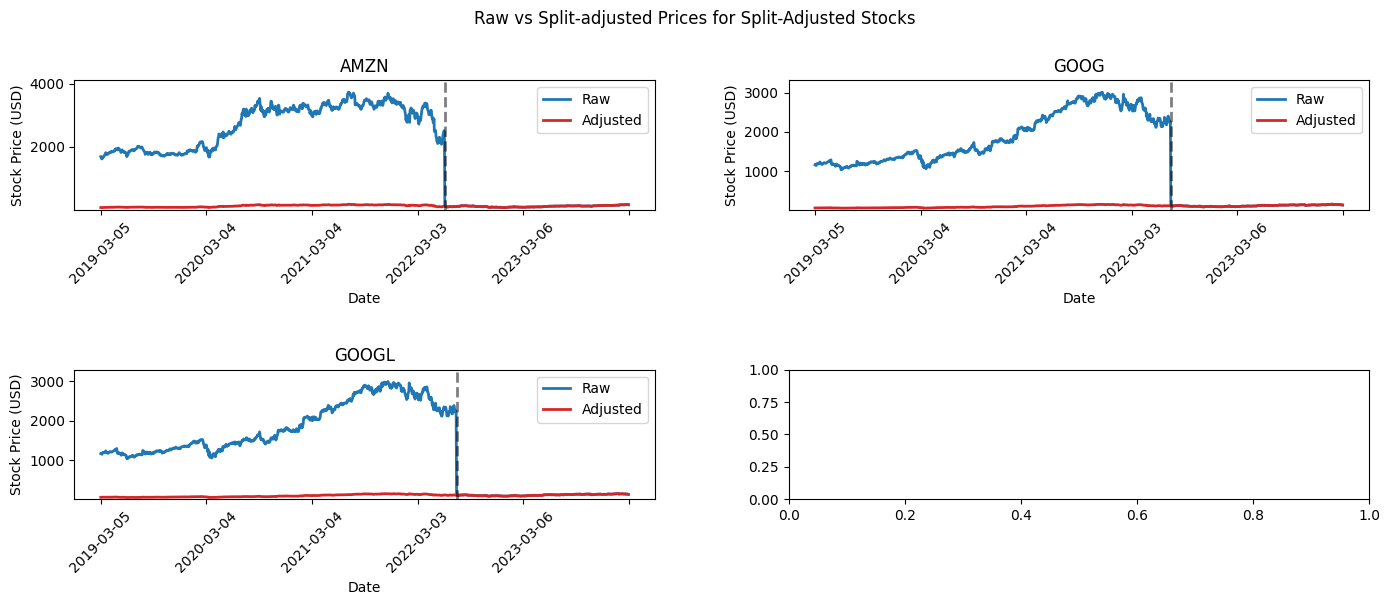

In [22]:
def plot_stock_splits(adjusted_dfs, dfs, split_df):
    """Visualizes split adjustments. 
    
    Args:
        adjusted_dfs (dict): A dictionary storing all datasets in which a split adjustment was made: 
                            key = stock symbol (str), value = split-adjusted stock data (pandas.DataFrame).
        dfs (dict): A dictionary storing all datasets under consideration: key = stock symbol (str), value = stock data (pandas.DataFrame).
                        Used for showing raw data compared to split-adjusted data.
        split_df (pandas.DataFrame): A DataFrame holding info on user-accepted split events.        
        
    Returns:
        None
    """ 

    num_plots = len(adjusted_dfs)  # one subplot per df
    num_cols = 2 if len(adjusted_dfs) > 1 else 1 #2 dfs per column
    num_rows = int(np.ceil(num_plots / num_cols)) # number of rows in figure

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(7*num_cols, 3*num_rows))
    if len(adjusted_dfs) > 1 :
        axes = axes.flatten()
    else : 
        axes = [axes]

    plt.suptitle("Raw vs Split-adjusted Prices for Split-Adjusted Stocks", y=1)

    for ax, symbol in zip(axes, adjusted_dfs) :
        max_y = max(dfs[symbol].Close.max(), adjusted_dfs[symbol].Close.max())*1.1        
        lw=2
        ax.plot(dfs[symbol].Date, dfs[symbol].Close, color='tab:blue', lw=lw, label='Raw')
        ax.plot(adjusted_dfs[symbol].Date, adjusted_dfs[symbol].Close, color='tab:red', lw=lw, label='Adjusted') 
        split_dates = [split_date for split_date in split_df.loc[split_df.Stock == symbol, 'Date']] #there might be multiple splits per stock during the period
        for date in split_dates:            
            ax.plot([date,date], [0,max_y], color='black', linestyle='--', alpha=0.5, lw=lw) #vertical line to indicate split event
        ax.legend()
        ax.set_title(symbol)
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price (USD)')
        ax.set_ylim(top=max_y, bottom=dfs[symbol].Close.min()*0.1 )
        ax.tick_params(axis='x', labelrotation=45)
        ax.xaxis.set_major_locator(plt.MultipleLocator(len(df) // 5))

    plt.tight_layout(w_pad = 5, h_pad = 3)
    plt.show()

if len(adjusted_dfs) > 0 :
    plot_stock_splits(adjusted_dfs, dfs, split_df)

 ## Store 'clean' data in the appropriate SQLite DB
- It is recommended to pre-process all tables from the original SQLite DB, and then store all 'clean' in a new SQLite file
- The clean SQLite file is intended to be gradually filled with each batch. However, if you want to overwrite certain tables, set replace_existing_tables to True in the beginning of this notebook
- The new SQLite file will contain split-adjusted data when a split was detected, or the raw data if not 

In [23]:
def copy_stocks_table():
    """If the clean SQLite DB doesn't contain our 'Stocks' table, add it.
    
    Args:
        None
        
    Returns:
        None
    """ 

    cur_clean.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='Stocks'")
    isstocks = cur_clean.fetchone()    
    
    if isstocks is not None: 
        print(f"'Stocks' table already exists in {sqlite_file_path_clean}.")
        return #if the table already exists, exit this function
        
    try:
        #get the schema of the source table
        cur.execute("SELECT sql FROM sqlite_master WHERE type='table' AND name='Stocks'")
        create_table_sql = cur.fetchone()[0]
        
        #create the table in the clean database
        cur_clean.execute(create_table_sql)
        
        #copy data from source table to destination table
        cur.execute("SELECT * FROM Stocks")
        rows = cur.fetchall()
        cur_clean.executemany(f"INSERT INTO Stocks VALUES ({','.join(['?'] * len(rows[0]))})", rows)
        conn_clean.commit()
        print(f"'Stocks' table successfully copied to {sqlite_file_path_clean}.")
    
    except sqlite3.Error as e:
        print("Error:", e)
        conn_clean.rollback()

copy_stocks_table()

'Stocks' table successfully copied to ./S&P 500_clean_api.sqlite.


In [24]:
#enter clean data into clean SQLite DB
def store_clean_data(dfs, adjusted_dfs) :
    """Store data for all pre-processed stocks in clean SQLite DB.
    
    Args:
        dfs (dict): A dictionary storing all datasets under consideration: key = stock symbol (str), value = stock data (pandas.DataFrame).
        adjusted_dfs (dict): A dictionary storing all datasets in which a split adjustment was made: 
                            key = stock symbol (str), value = split-adjusted stock data (pandas.DataFrame).                        
        
    Returns:
        None
    """ 

    for symbol, df in dfs.items() :
        try:
                
            if symbol in adjusted_dfs :
                adjusted_dfs[symbol].sort_values('Date', ascending=False).to_sql(symbol, conn_clean, index=False, if_exists='replace')
            else :
                dfs[symbol].sort_values('Date', ascending=False).to_sql(symbol, conn_clean, index=False, if_exists='replace')

        except sqlite3.Error as e:
            print(f"Error encountered for table '{symbol}'' :\n{e}")        

    conn_clean.commit()
    print(f"Inserted {len(dfs)} tables, including {len(adjusted_dfs)} split-adjusted tables into '{sqlite_file_path_clean}'.")
    cur_clean.execute("SELECT name FROM sqlite_master WHERE type='table' and name!='Stocks'")
    all_clean = cur_clean.fetchall()
    print(f"\nClean SQLite DB now contains info on {len(all_clean)} stocks.")


store_clean_data(dfs, adjusted_dfs)

Inserted 30 tables, including 3 split-adjusted tables into './S&P 500_clean_api.sqlite'.

Clean SQLite DB now contains info on 30 stocks.


In [25]:
#close connections to SQLite files
conn.close()
conn_clean.close()